In [2]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2021-01-01/2021-12-31"

In [5]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 13 Items


In [6]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


In [7]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [9]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 747, x: 795)
Coordinates:
  * y            (y) float64 6kB 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 6kB 5.543e+05 5.544e+05 ... 5.781e+05 5.782e+05
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2021-07-25T18:55:39.475647
Data variables:
    nir08        (y, x) uint16 1MB 7187 7216 7237 7251 ... 20871 20917 23931
    red          (y, x) uint16 1MB 7158 7193 7219 7246 ... 8171 9372 8634 8058
    green        (y, x) uint16 1MB 7489 7518 7541 7570 ... 8771 9580 9062 8709
    blue         (y, x) uint16 1MB 7343 7370 7433 7467 ... 8068 8616 8252 8014
    qa_pixel     (y, x) uint16 1MB 21952 21952 21952 21952 ... 21824 21824 21824
    lwir11       (y, x) uint16 1MB 43466 43464 43468 43471 ... 44431 44355 44229

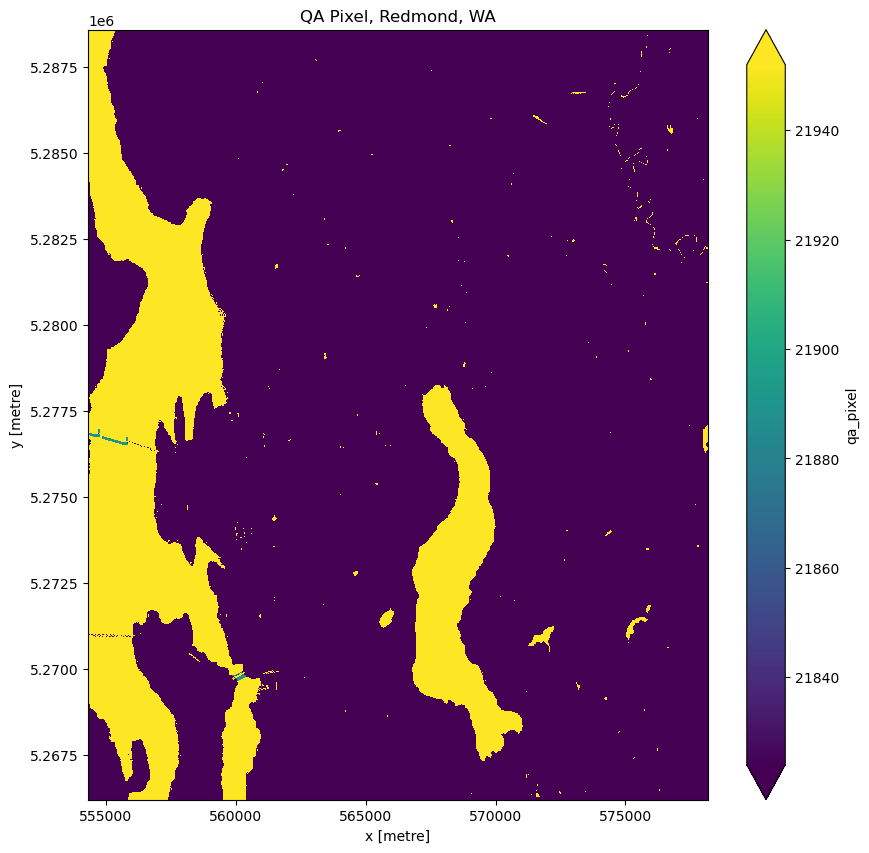

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
data["qa_pixel"].plot.imshow(robust=True, ax=ax)
ax.set_title("QA Pixel, Redmond, WA");

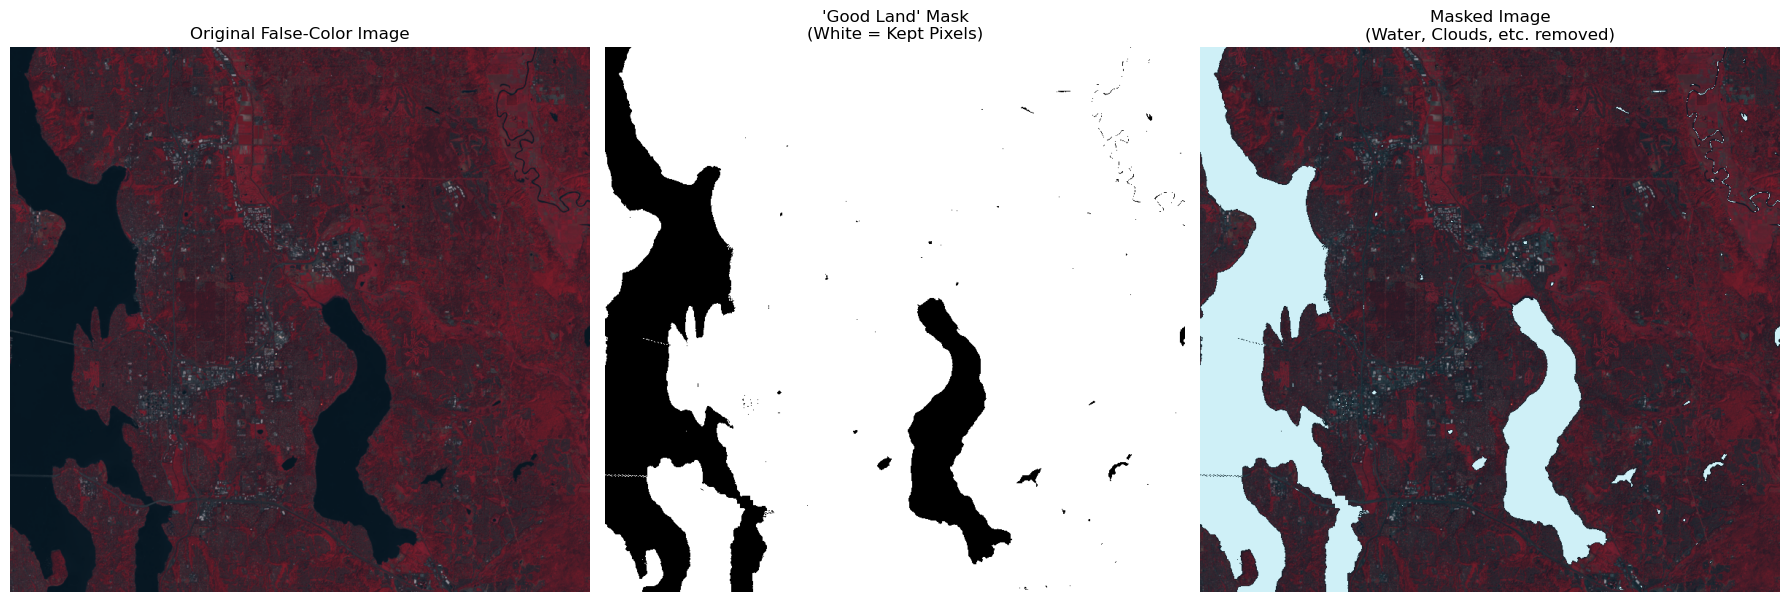

In [15]:
qa_band = data.qa_pixel

# 2. 定义我们不想要的像素条件的对应位
# 根据上面的表格，我们想排除扩张云、云、云影和水体
dilated_cloud_bit = 1
cloud_bit = 3
cloud_shadow_bit = 4
water_bit = 7

# 3. 为每个条件创建单独的掩码
# 我们通过位运算检查该位是否为0。如果为0，说明不是该种类的像素，是我们想要的
mask_dilated_cloud = (qa_band & (1 << dilated_cloud_bit)) == 0
mask_cloud = (qa_band & (1 << cloud_bit)) == 0
mask_cloud_shadow = (qa_band & (1 << cloud_shadow_bit)) == 0
mask_water = (qa_band & (1 << water_bit)) == 0

# 4. 合并所有掩码
# 一个像素必须同时满足所有条件（都不是云、都不是水等），才被认为是好像素
# 因此我们使用逻辑“与”(&)操作
good_quality_mask = (
    mask_dilated_cloud & mask_cloud & mask_cloud_shadow & mask_water
)

# 5. 将掩码应用到你的数据上
# .where() 函数会保留掩码中为 True 的像素，将 False 的像素替换为 NaN (Not a Number)
data_masked = data.where(good_quality_mask)

# --- 可视化对比 ---
import numpy as np

# 定义一个函数，用于将数据缩放到 0-255 以便绘图
def scale_to_uint8(da):
    # 使用 fillna(0) 来处理掩码应用后产生的 NaN 值
    return ((da.fillna(0) - da.min()) / (da.max() - da.min()) * 255).astype(np.uint8)

# 创建一个假彩色影像 (NIR, Red, Green)
# 这种组合能让植被显示为红色，水体为深色，更利于观察
rgb_composite_original = np.stack([
    scale_to_uint8(data.nir08),
    scale_to_uint8(data.red),
    scale_to_uint8(data.green)
], axis=-1)

# 创建应用掩码后的假彩色影像
rgb_composite_masked = np.stack([
    scale_to_uint8(data_masked.nir08),
    scale_to_uint8(data_masked.red),
    scale_to_uint8(data_masked.green)
], axis=-1)

# 绘制对比图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 图1: 原始假彩色影像
axes[0].imshow(rgb_composite_original)
axes[0].set_title("Original False-Color Image")
axes[0].set_axis_off()

# 图2: 生成的质量掩码
# 白色部分 (True) 是我们保留的有效陆地像素
axes[1].imshow(good_quality_mask, cmap='gray')
axes[1].set_title("'Good Land' Mask\n(White = Kept Pixels)")
axes[1].set_axis_off()

# 图3: 应用掩码后的影像
axes[2].imshow(rgb_composite_masked)
axes[2].set_title("Masked Image\n(Water, Clouds, etc. removed)")
axes[2].set_axis_off()

plt.tight_layout()
plt.show()